

<center><h1>Tutorial: Synaptic connectivity and dynamics in mouse and human cortex</h1></center>
<p style="font-size: 16pt; text-align: center;">
</p><br>

This tutorial will show you how to access the [Synaptic Physiology Dataset](https://portal.brain-map.org/explore/connectivity/synaptic-physiology) from the Allen Institute for Brain Science. This dataset describes properties of synapses that were recorded using patch-clamp electrophysiology in mouse and human neocortical tissue. The main purpose is to understand the relationship between _cell types_ and _synapse properties_ in local microcircuits:

- What is the probability of finding a synaptic connection between two cells, and how is that affected by cell type? 
- How is connectivity affected by the distance between two cells, or by other experimental parameters?
- How is cell type related to other synapse properties such as strength, latency, kinetics (PSP shape), and dynamics (stochasticity and short-term plasticity)?
- How can we best model synaptic connectivity and dynamics, and what can these models tell us about the function of the microcircuit?

<div style="background-color: #CCC; padding-bottom: 6pt; padding-left: 15pt; padding-top: 1pt; border-radius: 5pt;">
    <h2>Multi-patch electrophysiology</h2>
</div>

The experiments in the Synaptic Physiology Dataset are performed using patch clamp electrophysiology in brain slices with up to 8 electrodes simultaneously. The resulting data are complex; understanding the limitations of the experimental methods is necessary in order to avoid analysis mistakes. For complete details on our methods, see our  [website](https://portal.brain-map.org/explore/connectivity/synaptic-physiology) and recent [bioRxiv publication](https://www.biorxiv.org/content/10.1101/2021.03.31.437553v2). When in doubt, you can ask questions on our [forum](https://community.brain-map.org/) with the tag `synaptic-physiology`.

In patch-clamp electrophysiology, we use glass electrodes to gain direct electrical access to the _interior_ of a neuron. This allows us to precisely control the spiking of individual cells and to record synaptic currents that are too small to be observed by any other method (for now). 

![multipatch](source/images/multipatch.svg)

In a single experiment, we patch up to 8 neurons simultaneously. Each neuron is stimulated to fire patterns of action potentials while we record the membrane potential of the other neurons. If two neurons are connected by a synapse, we should be able to see synaptic currents within a few ms of each presynaptic spike (although many synapses require averaging to reduce noise before the response is visible).

<div style="background-color: #CCC; padding-bottom: 6pt; padding-left: 15pt; padding-top: 1pt; border-radius: 5pt;">
    <h2>Synapse characterization</h2>
</div>

Each synapse in our dataset is characterized by their responses to many presynaptic spikes -- each spike elicits a "postsynaptic potential" (PSP), and by looking at many responses we can determine properties such as the average amplitude, the latency from spike to response, the PSP shape, and the trial-to-trial variance. 

![psp_measurements](source/images/psp_measurements.svg)

We also rapidly stimulate each cell to determine how the synapse reacts dynamically -- many synapses will either *facilitate* or *depress* in this situation.


<a name="introduction"></a>

<div style="background-color: #CCC; padding-bottom: 6pt; padding-left: 15pt; padding-top: 1pt; border-radius: 5pt;">
    <h2>Dataset and database</h2>
</div>

The Synaptic Physiology Dataset contains the results of thousands of multipatch experiments. For each experiment, we store three major types of information:

- **Experiment metadata:** species, brain region, and experimental conditions
- **Cell properties:** location (including cortical layer), morphology, transgenic reporters, and intrinsic electrophysiological features
- **Synapse properties:** strength, latency, kinetics (PSP shape), and dynamics (variance and short-term plasticity)

These data are stored in a relational database (an sqlite file) and spread out over many tables. It is possible to access these tables using SQL or sqlalchemy; however, for this tutorial we will use helper methods that handle most of the queries for us.

![database_schema](source/images/synphys_20_simple.svg)

The diagram above shows a selection of more commonly-used resources in the relational database. The complete set of tables and columns is decribed in the [schema documentation](https://aisynphys.readthedocs.io/en/master/api_schema.html).

Querying synapse data
---------------------

As a simple starting point, let's get a dataframe that describes the properties of all human synapses in the dataset. We will use the function `db.pair_query`, which returns one row for each _cell pair_ in the database. Cell pairs are _ordered_, which means that the connections from cell A→B and cell B→A will have two different rows.

In [1]:
from aisynphys.database import SynphysDatabase
db = SynphysDatabase.load_current('small')

query = db.pair_query(
    experiment_type='standard_multipatch',   # filter: just multipatch experiments
    species='human',                         # filter: only human data
    synapse=True,                            # filter: only cell pairs connected by synapse
    synapse_type='ex',                       # filter: only excitatory synapses
    preload=['synapse', 'cell'],             # include extra tables that contain synapse AND cell properties
)
synapses = query.dataframe()                 # query all records and convert to pandas dataframe

print(f"Loaded {len(synapses)} synapses")
synapses.head()

  /home/luke/ai_synphys_cache/database/synphys_r2.0-pre4_small.sqlite
  [####################]  100.00% (160.52 MB / 160.5 MB)  10.298 MB/s  0:00:00 remaining
  done.
Loaded 376 synapses


,pair.id,pair.experiment_id,pair.pre_cell_id,pair.post_cell_id,pair.has_synapse,pair.has_polysynapse,pair.has_electrical,pair.crosstalk_artifact,pair.n_ex_test_spikes,pair.n_in_test_spikes,...,synapse_model.ml_variability_stp_induced_state_50hz,synapse_model.ml_variability_change_initial_50hz,synapse_model.ml_variability_change_induction_50hz,synapse_model.ml_paired_event_correlation_1_2_r,synapse_model.ml_paired_event_correlation_1_2_p,synapse_model.ml_paired_event_correlation_2_4_r,synapse_model.ml_paired_event_correlation_2_4_p,synapse_model.ml_paired_event_correlation_4_8_r,synapse_model.ml_paired_event_correlation_4_8_p,synapse_model.meta
0,56768,1650,9834,9829,True,False,False,NaN,772,59,...,-0.537358,0.238305,0.522540,0.004416,0.921544,-0.048564,0.278435,0.040824,0.362318,{'pair_ext_id': '1525829536.548 7 2'}
1,56794,1651,9841,9840,True,False,False,NaN,154,84,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
2,56787,1651,9841,9836,True,False,False,NaN,84,84,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
3,56733,1651,9837,9839,True,False,False,NaN,516,84,...,0.551889,0.502588,1.633543,0.022635,0.613610,-0.086233,0.053981,-0.050557,0.259160,{'pair_ext_id': '1525841351.681 2 4'}
4,56718,1651,9836,9837,True,False,False,NaN,680,84,...,1.532516,0.034194,1.450314,0.046353,0.300931,-0.061078,0.172695,0.056326,0.208631,{'pair_ext_id': '1525841351.681 1 2'}


In [2]:
synapses['pre_cortical_cell_location.cortical_layer'].unique()

array(['3', None, '2', '4', '5', '6', '1'], dtype=object)

This dataframe contains many columns that describe the properties of each synapse. These columns are described in the [documentation](https://aisynphys.readthedocs.io/en/master/api_schema.html), but a few common ones are:

|                                    |                                               |
|:-----------------------------------|:----------------------------------------------|
| **synapse.psp_amplitude**              | Median amplitude of resting-state PSPs        |
| **synapse.latency**                    | Time between presynaptic spike and PSP onset  |
| **synapse.psp_rise_time**              | Time from onset to peak of averaged PSP       |
| **synapse.psp_decay_tau**              | Time constant of PSP decay phase              |
| **dynamics.stp_induction_50hz**        | A metric of synaptic facilitation / depression induced by 50 Hz spike trains           |
| **dynamics.variability_resting_state** | Adjusted coefficient of variation of PSP amplitudes |


<AxesSubplot:xlabel='synapse.psp_amplitude', ylabel='Count'>

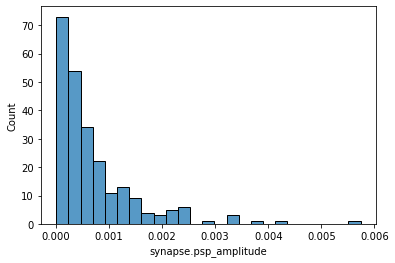

In [3]:
import seaborn
import matplotlib.pyplot as plt

seaborn.histplot(synapses['synapse.psp_amplitude'])

<a name="cell_types"></a>

<div style="background-color: #CCC; padding-bottom: 6pt; padding-left: 15pt; padding-top: 1pt; border-radius: 5pt;">
    <h2>Comparing synapse properties across cell types</h2>
</div>

To make the most of this dataset, we will usually want to group synapses based on the cells they connect. For example, how do human synapses differ when their cells are in layer 2 versus layer 3? The dataset offers several sources of information for grouping cells together:

![cell_selection](source/images/cell_selection.svg)


To begin grouping the data, we need to know where to find the relevant cell properties in our dataframe. Again, we could check the [documentation](https://aisynphys.readthedocs.io/en/master/api_schema.html#cell), but the most commonly used cell features are:

|                 |               |
|:----------------|:--------------|
| **cell.cell_class** | 'ex' (excitatory) or 'in' (inhibitory) |
| **cell.cre_type**  | Cre reporter observed in cell (mouse only for now) |
| **cortical_cell_location.cortical_layer** | Cortical layer of cell soma |
| **morphology.dendrite_type** | 'spiny' (excitatory cells), 'aspiny' (inhibitory cells), or 'sparsely spiny' (ambiguous) |

Note that, in the dataframe, each of the column names above is prepended with either `pre_` or `post_`, depending on which cell is described.

<AxesSubplot:xlabel='pre_cortical_cell_location.cortical_layer', ylabel='dynamics.stp_induction_50hz'>

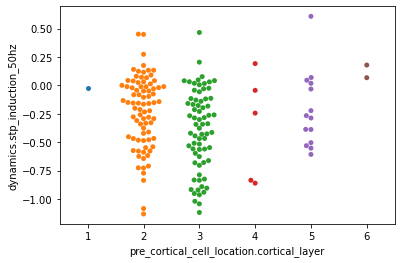

In [4]:
fig,ax = plt.subplots()
# ax.set_yscale('log')
seaborn.swarmplot(
    data=synapses, 
    x='pre_cortical_cell_location.cortical_layer', 
    y='dynamics.stp_induction_50hz', 
    order=['1', '2', '3', '4', '5', '6'],
    ax=ax,
)

Above we can see that most of the synapses in our human dataset are from layers 2 and 3, and also that layer 2 cells tend to express more synaptic facilitation compared to layer 3. 


### Defining more complex cell categories

The approach above can take us a long way, but eventually we will want to categorize cells based on more complex criteria, which can get a little messy. To make this easier, we provide tools that take care of the most common tasks in cell categorization. In the example below, we define a set of mouse cell classes based on a combination of transgenic (CRE) reporters, cortical layer, and dendrite morphology:

In [5]:
from aisynphys.cell_class import CellClass, classify_pair_dataframe

cell_categories = {
        'L2/3 Excit.': CellClass(cell_class='ex',  cortical_layer='2/3'),
         'L2/3 Pvalb': CellClass(cre_type='pvalb', cortical_layer='2/3'),
           'L2/3 Sst': CellClass(cre_type='sst',   cortical_layer='2/3'),
           'L2/3 Vip': CellClass(cre_type='vip',   cortical_layer='2/3'),
}

We have defined 4 cell categories above. Three categories are layer 2/3 inhibitory cells that express either Pvalb, Sst, or Vip. The fourth category include all excitatory cells in layer 2/3. These cells might be identified by any combination of excitatory transgenic markers, dendritic morphology, or excitatory synapse projection. Next, we will  load all mouse synapses from the database and create 2 new dataframe columns that indicate the categories of pre- and postsynaptic cells:

In [6]:
# load a dataframe of all all mouse synapses
query = db.pair_query(
    experiment_type='standard_multipatch',   # filter: just multipatch experiments
    species='mouse',                         # filter: only human data
    synapse=True,                            # filter: only cell pairs connected by synapse
    preload=['synapse', 'cell'],             # include extra tables that contain synapse AND cell properties
)
synapses = query.dataframe()                 # query all records and convert to pandas dataframe
print(f"Loaded {len(synapses)} synapses")

Loaded 2555 synapses


In [7]:
# add columns giving categories for pre and postsynaptic cells
classify_pair_dataframe(cell_categories, synapses, col_names=('pre_category', 'post_category'))

# check:
synapses['pre_category'].unique()

array([None, 'L2/3 Pvalb', 'L2/3 Sst', 'L2/3 Vip', 'L2/3 Excit.'],
      dtype=object)

.. and with our cells categorized, we can now display any metrics grouped by those categories. We have 4 categories of presynaptic cells, and 4 of postsynaptic cells, for a total of 16 pre/post combinations. If we ask pandas to make a pivot table based on these categories, we can easily visualize the matrix of results:

In [8]:
latency = synapses.pivot_table(
    values='synapse.latency',
    index='pre_category',
    columns='post_category',
    aggfunc='mean',
    fill_value=float('nan'),
)

latency

post_category,L2/3 Excit.,L2/3 Pvalb,L2/3 Sst,L2/3 Vip
pre_category,,,,
L2/3 Excit.,0.001930,0.001350,0.001548,0.001717
L2/3 Pvalb,0.000936,0.001091,0.001009,NaN
L2/3 Sst,0.001119,0.001420,0.001399,0.001054
L2/3 Vip,0.001723,0.001438,0.001569,0.002233


Pandas generates the pivot table above by combining several steps:
1. Create a table with all possible `pre_category` values as rows, and all possible `post_category` values as columns.
2. For each element in this table, group together all rows from the dataframe that have this combination of `pre_category` and `post_category`. 
3. Insert into each table element the mean of `synapse.latency` for all rows that were grouped to that element.

With seaborn, we can visualize this table as a heatmap:

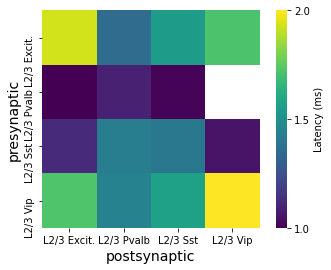

In [9]:
import seaborn as sns

hm = sns.heatmap(
    latency * 1000, 
    cmap='viridis', vmin=1, vmax=2, square=True,
    cbar_kws={"ticks":[1, 1.5, 2], 'label': 'Latency (ms)'}
)
hm.set_xlabel("postsynaptic", fontsize=14)
hm.set_ylabel("presynaptic", fontsize=14);

The procedure above is common enough that a single function exists to run the database query, cell categorization, and plotting all in one. Let's try this with a less restrictive set of cell categories:

In [10]:
cell_categories = {
    'Excit.': CellClass(cell_class='ex'),
     'Pvalb': CellClass(cre_type='pvalb'),
       'Sst': CellClass(cre_type='sst'),
       'Vip': CellClass(cre_type='vip'),
}

/home/luke/miniconda3/envs/aisynphys/lib/python3.9/site-packages/pandas/io/sql.py:1424: SAWarning: TypeDecorator FloatType() will not produce a cache key because the ``cache_ok`` flag is not set to True.  Set this flag to True if this type object's state is safe to use in a cache key, or False to disable this warning.
  return self.connectable.execution_options().execute(*args, **kwargs)


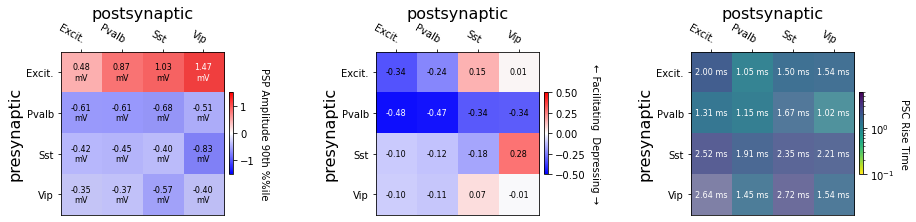

In [11]:
import matplotlib.pyplot as plt
from aisynphys.ui.notebook import cell_class_matrix

fig,ax = plt.subplots(1, 3, figsize=(16, 3))

metrics = ['pulse_amp_90th_percentile', 'stp_induction_50hz', 'psc_rise_time']

for i, metric in enumerate(metrics):
    cell_class_matrix(
        pre_classes=cell_categories, 
        post_classes=cell_categories,
        metric=metric, 
        class_labels=None, ax=ax[i],
        db=db, pair_query_args={
            'experiment_type': 'standard multipatch',
            'synapse': True,
            'species': 'mouse',
        }
    );

<a name="connectivity"></a>

Measuring connectivity
---------------------------------

If we check two cells at random, what is the probability of finding a connection between them? If I want to build a network model of the cortex, which cells should I connect together? Measuring connectivity in a dataset like this can be surprisingly complex. Several factors can affect the connectivity we see:

- Cell type-dependent differences in connectivity
- Spatial effects of connectivity--intersomatic distance and relative positioning
- False negatives:
  - Connections severed during tissue preparation
  - Synapses with low SNR
  
The first approach we will make to measure connectivity considers only the first point--we will look at the _proportion_ of cell pairs that were connected, grouped by cell type.

In [10]:
mouse_pairs = db.pair_query(
    experiment_type='standard multipatch',  # filter: just multipatch experiments
    species='mouse',                        # filter: only mouse data
    synapse_probed=True,                    # filter: only cell pairs that were checked for connectivity
    preload=['cell']                        # include tables that describe cell properties
).dataframe()

print(f"Loaded {len(mouse_pairs)} cell pairs")

Loaded 23311 cell pairs


A single row in this dataframe contains information about a cell pair, which represents a _possible_ connection from one cell to another.

Note that in prior queries we used `synapse=True` to select only connected cell pairs. Here we are interested in measuring connectivity, so we also need to know about pairs that were checked for connectivity, but where no connection was found. So instead, we used `synapse_probed=True`, which returns all cell pairs that were checked for connectivity, regardless of whether a connection was found.

Next, we categorize all cells like before, and then measure the proportion of connected pairs for each group:

In [13]:
# add two new columns with pre- and postsynaptic cell categories
classify_pair_dataframe(cell_categories, mouse_pairs, col_names=('pre_category', 'post_category'))

# make a pivot table count the number of pairs in each matrix element
probed = mouse_pairs.pivot_table(
    values='pair.id', index='pre_category', columns='post_category', 
    aggfunc=len, fill_value=1
)

# pivot again, but this time count the connected pairs
connected = mouse_pairs.pivot_table(
    values='pair.has_synapse', index='pre_category', columns='post_category', 
    aggfunc=sum, fill_value=0
)

# show the table of connected proportions
connected / probed

post_category,Excit.,Pvalb,Sst,Vip
pre_category,,,,
Excit.,NaN,NaN,NaN,NaN
Pvalb,NaN,NaN,NaN,NaN
Sst,NaN,NaN,NaN,NaN
Vip,NaN,NaN,NaN,NaN


### Connectivity across layer

Now let's define a larger list of cell classes that combine cortical layer, transgenic types, and morphology:

In [6]:
from aisynphys.cell_class import CellClass
import matplotlib.pyplot as plt

In [4]:
cell_category_criteria = {
    'l23pyr': {'dendrite_type': 'spiny',       'cortical_layer': '2/3'},
    'l23pv':  {'cre_type': 'pvalb',            'cortical_layer': '2/3'},
    'l23sst': {'cre_type': 'sst',              'cortical_layer': '2/3'},
    'l23vip': {'cre_type': 'vip',              'cortical_layer': '2/3'},
    'l4pyr':  {'cre_type': ('nr5a1', 'rorb'),  'cortical_layer': '4'},
    'l4pv':   {'cre_type': 'pvalb',            'cortical_layer': '4'},
    'l4sst':  {'cre_type': 'sst',              'cortical_layer': '4'},
    'l4vip':  {'cre_type': 'vip',              'cortical_layer': '4'},
    'l5et':   {'cre_type': ('sim1', 'fam84b'), 'cortical_layer': '5'},
    'l5it':   {'cre_type': 'tlx3',             'cortical_layer': '5'}, 
    'l5pv':   {'cre_type': 'pvalb',            'cortical_layer': '5'},
    'l5sst':  {'cre_type': 'sst',              'cortical_layer': '5'},
    'l5vip':  {'cre_type': 'vip',              'cortical_layer': '5'},
    'l6pyr':  {'cre_type': 'ntsr1',            'cortical_layer': ('6a','6b')},
    'l6pv':   {'cre_type': 'pvalb',            'cortical_layer': ('6a','6b')},
    'l6sst':  {'cre_type': 'sst',              'cortical_layer': ('6a','6b')},
    'l6vip':  {'cre_type': 'vip',              'cortical_layer': ('6a','6b')},
}

cell_categories = {k:CellClass(name=k, **v) for k,v in cell_category_criteria.items()}

c:\users\stephanies\aisynphys\aisynphys\connectivity.py:322: RuntimeWarning: Mean of empty slice.
  mean_cp = np.exp(-x_probed**2 / (2 * sigma**2)).mean()
c:\users\stephanies\appdata\local\continuum\miniconda3\envs\py3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\users\stephanies\aisynphys\aisynphys\connectivity.py:328: RuntimeWarning: invalid value encountered in long_scalars
  est_pmax = (n_conn / n_test) / mean_cp


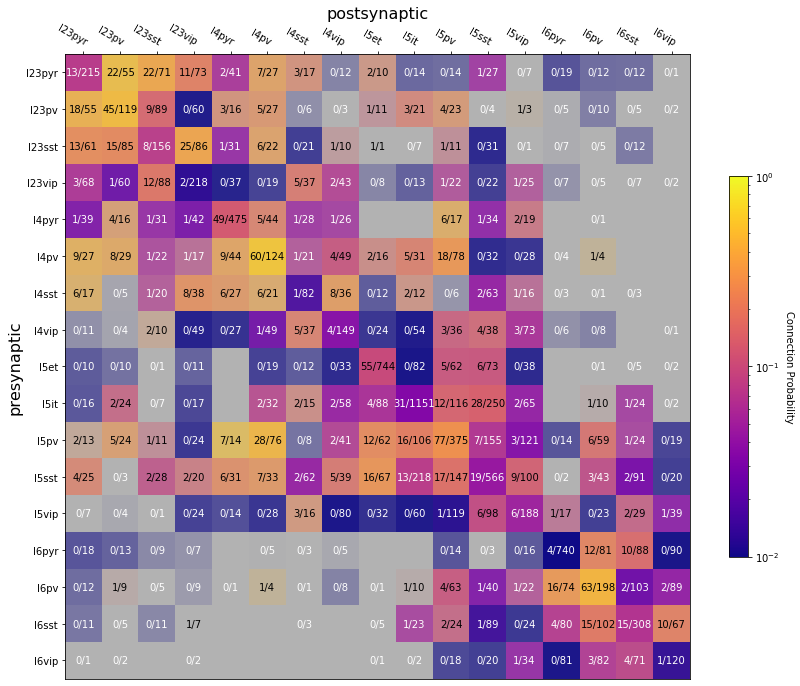

In [7]:
from aisynphys.ui.notebook import generate_connectivity_matrix

fig, ax = plt.subplots(figsize=(14,14))

generate_connectivity_matrix(
    db=db,
    cell_classes=cell_categories,
    pair_query_args={
        'experiment_type': 'standard multipatch',
        'species': 'mouse',
        'synapse_probed': 'True',
    },
    ax=ax,
);

### Modeling connectivity versus intersomatic distance

The analysis above gives us an estimate of the relative connectivities between cell types, but leaves out some important details. In particular, we know that the probability of finding a connection between any two cells is strongly related to the spatial relationship between the cells and their axo-dendritic morphology.

As an approximation, we think of cell morphology as being cylindrically symmetrical around the axis perpendicular to the cortical surface. This means that the likelihood of two cells being connected by a synapse is strongly related to the _lateral_ distance between their cell bodies (the distance parallel to the cortical surface). 


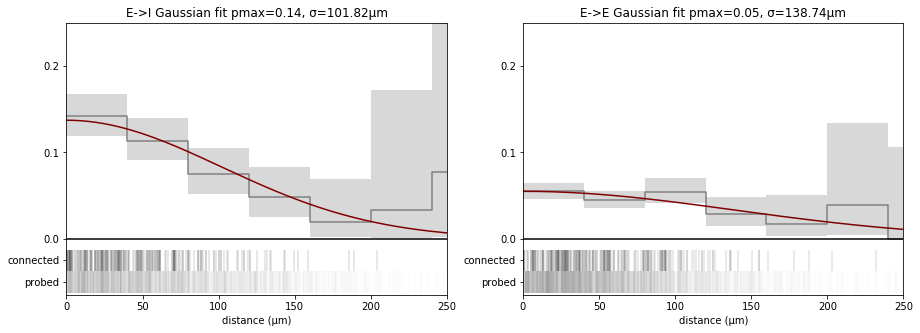

In [16]:
from aisynphys.ui.notebook import show_connectivity_profile
from aisynphys.connectivity import GaussianModel

ei_mask = (
    (mouse_pairs['pre_cell.cell_class'] == 'ex') & 
    (mouse_pairs['post_cell.cell_class'] == 'in') &
    (mouse_pairs['pair.lateral_distance'] < 500e-6)
)

ee_mask = (
    (mouse_pairs['pre_cell.cell_class'] == 'ex') & 
    (mouse_pairs['post_cell.cell_class'] == 'ex') &
    (mouse_pairs['pair.lateral_distance'] < 500e-6)
)

fig,ax = plt.subplots(1, 2, figsize=(15, 5))

for i, (label, mask) in enumerate({'E->I': ei_mask, 'E->E': ee_mask}.items()):
    x_probed = mouse_pairs[mask]['pair.lateral_distance'].to_numpy(dtype=float)
    conn = mouse_pairs[mask]['pair.has_synapse'].to_numpy(dtype=bool)

    fit = GaussianModel.fit(x_probed, conn)
    show_connectivity_profile(x_probed, conn, ax[i], fit, ymax=0.25)

    ax[i].set_xlim(0, 250e-6)
    ax[i].set_title(f"{label} Gaussian fit pmax={fit.pmax:0.2f}, σ={fit.size*1e6:0.2f}μm")

# print(f"E->I Gaussian fit pmax={fit.pmax:0.2f}, σ={fit.size*1e6:0.2f}μm")

### Correcting for bias in connectivity measurements

We see above that there is a steep relationship between intersomatic distance and the probability of connectivity. A consequence is that, if two groups of connections are sampled with different intersomatic distances, then they may appear to have different rates of connectivity simply as an experimental artifact. This relationship is further influenced by cell type, in this case impacting E->I connections more so than E->E connections

Likewise, we have two other major sources of experimental artifacts:
- Connections damaged during tissue dissection
- Connections missed due to low signal to noise ratio

These artifacts are present within our dataset, and they are especially prominent when comparing results across  studies that may use very different experimental protocols. It is possible, however, to model these effects and estimate the unbiased connectivity. 

For more on this, please see our [manuscript on bioRxiv](https://www.biorxiv.org/content/10.1101/2021.03.31.437553v2), as well as [this supplementary notebook]().

<a name="model"></a>

Stochastic release model
---------------------------------------

Above, we looked briefly at features that describe the dynamic behavior of synapses including stochasticity and short-term plasticity. Those features are useful for comparing synapses, but make an incomplete description of synapse behavior. To capture a more complete description of synaptic dynamics, we use a model of stochastic vesicle release.

Conceptually, the model is simple: given a list of presynaptic spike times, predict the distribution of likely response amplitudes after each spike. The model has several parameters that combine standard quantal release and short-term plasticity features:

| Parameter | Description |
|----------:|:------------|
| n_release_sites | Number of synaptic release zones |
| base_release_probability | Resting-state synaptic release probability (0.0-1.0) |
| mini_amplitude | Mean PSP amplitude evoked by a single vesicle release |
| mini_amplitude_cv | Coefficient of variation of PSP amplitude evoked from single vesicle releases |
| depression_amount | Amount of depression (0.0-1.0) to apply per spike. -1 enables vesicle depletion rather than Pr depression. |
| depression_tau | Time constant for recovery from depression or vesicle depletion |
| facilitation_amount | Release probability facilitation per spike (0.0-1.0) |
| facilitation_tau | Time constant for facilitated release probability to recover toward resting state |
| measurement_stdev | Extra variance in PSP amplitudes purely as a result of membrane noise / measurement error |

Many synapses in the database include maximum-likelihood parameters that can be used to seed this model and make predictions about how the synapse would respond to any input.

In [17]:
from aisynphys.stochastic_release_model import StochasticReleaseModel, StochasticModelRunner

synapses = db.pair_query(
    experiment_type='standard multipatch',  # filter: just multipatch experiments
    species='human',                        # filter: only human data
    synapse=True,                           # filter: only cell pairs that are connected by a synapse
    preload=['cell', 'synapse']             # include tables that describe cell and synapse properties
).dataframe()

In [18]:
# select only synapses with max likelihood model parameters
mask = ~synapses['synapse_model.ml_n_release_sites'].isna()

# pick a random synapse
synapse = synapses[mask].iloc[123]

# make a dictionary of model parameters
model_params = {param:synapse[f'synapse_model.ml_{param}'] for param in StochasticReleaseModel.param_names}
model_params['n_release_sites'] = int(model_params['n_release_sites'])
model_params

{'n_release_sites': 3,
 'base_release_probability': 0.762698585902344,
 'mini_amplitude': 0.000333520496496931,
 'mini_amplitude_cv': 0.251188643150958,
 'depression_amount': 0.125,
 'depression_tau': 0.107672015410588,
 'facilitation_amount': 0.375,
 'facilitation_tau': 2.56,
 'measurement_stdev': 8.62167096775792e-05}

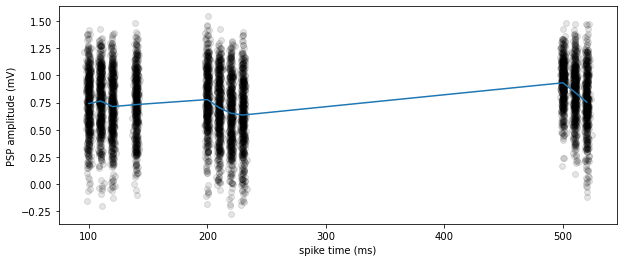

In [19]:
import numpy as np

# Instantiate a model with the ML parameters chosen above
model = StochasticReleaseModel(model_params)

# Make up a list of presynaptic spike times to test
spike_times = np.array([0.1, 0.11, 0.12, 0.14, 0.2, 0.21, 0.22, 0.23, 0.5, 0.51, 0.52])

# Run the model many times
n_trials = 500
psp_amps = np.empty((n_trials, len(spike_times)))
for i in range(n_trials):
    model_result = model.run_model(spike_times, amplitudes='random')
    psp_amps[i] = model_result.result['amplitude']
    
# Plot the results
fig,ax = plt.subplots(figsize=(10, 4))
for i in range(n_trials):
    ax.scatter(
        spike_times * 1000 + np.random.normal(size=len(spike_times)), 
        psp_amps[i] * 1000, 
        color=(0, 0, 0, 0.1)
    )
    
ax.plot(spike_times * 1000, psp_amps.mean(axis=0) * 1000)
ax.set_xlabel('spike time (ms)')
ax.set_ylabel('PSP amplitude (mV)');